# Experience

This experience shows an approach used to perform Time-Series data analysis involving Machine Learning for a MSc Thesis project called 'Observing and Controlling Performance in Microservices'.

### Context:
For this experience, there are values stored in a Time-Series database to be analysed. This values represent metrics extracted from a span data produced by a certain system.

### Objective:
The objective resides in answer the question related to anomaly detection: "Is there any faulty service?". To do this we use three questions:
1. Does any service present a significant change in the number of incoming requests?
2. Does any service present a significant change in the number of outgoing requests?
3. Does any service present a significant change in the response time?

### Features involved:
- Call count [IN] -- (Question 1);
- Call count [OUT] -- (Question 2);
- Response time -- (Question 3);

### Considerations:
- Multiple features to be analyzed;
- Possible correlation between features;
- Unlabeled data --> (Un)supervised learning;

In [1]:
import pandas as pd

from os import path
import sys
sys.path.append(path.abspath('/mnt/B6C8BAECC8BAAA4F/André/UC/Tese/MScThesis/Graphy'))

import graphy
from graphy.db import opentsdb

# Data to be analyzed

The data is gathered from a Time-Series database (OpenTSDB). In this case we get some metrics from this kind of database to perform the analysis.

We are using the OUTER JOIN method to merge data from multiple features. This merge method preserves the data points and fills the missing values with NaN (Missing values).

In [2]:
start_timestamp = 1530057600
end_timestamp = 1530316800

service_name = 'nova-api-cascading'

metric_name = 'huawei.call_count_in.{}'.format(service_name)
metric_name_2 = 'huawei.call_count_out.{}'.format(service_name)
metric_name_3 = 'huawei.response_time_avg.{}'.format(service_name)

metrics = opentsdb.get_metrics(metric_name, start_timestamp, end_timestamp)
metrics_2 = opentsdb.get_metrics(metric_name_2, start_timestamp, end_timestamp)
metrics_3 = opentsdb.get_metrics(metric_name_3, start_timestamp, end_timestamp)

# print(len(metrics.items()))
# print(len(metrics_2.items()))
# print(len(metrics_3.items()))

df_1 = pd.DataFrame(metrics.items(), columns=['time', 'call_count_in'])
df_2 = pd.DataFrame(metrics_2.items(), columns=['time', 'call_count_out'])
df_3 = pd.DataFrame(metrics_3.items(), columns=['time', 'response_time_avg'])

df = pd.merge(df_1, df_2, how='outer')
df = pd.merge(df, df_3, how='outer')

print('\nData info:\n{}'.format(df.info()))

print('\nData:\n{}'.format(df))

print('\nMissing values counting:\n{}'.format(df.isna().sum()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 4 columns):
time                 1341 non-null object
call_count_in        1341 non-null int64
call_count_out       1272 non-null float64
response_time_avg    1341 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 52.4+ KB

Data info:
None

Data:
            time  call_count_in  call_count_out  response_time_avg
0     1530137700            450           308.0      152401.703125
1     1530138135            163           108.0      154017.812500
2     1530138150            402           274.0      151387.281250
3     1530138165            239           166.0      149441.390625
4     1530138195             48            34.0      161604.000000
5     1530138210             48            34.0      161604.000000
6     1530138300            450           308.0      152401.703125
7     1530138600            450           308.0      152401.703125
8     1530140670            515    

# Plotting

In this code block, for visualization purposes, we plot some data retrieved from the time-series database.

As we can see, there are missing points in some charts. To perform a good analysis, this problem must be solved.

In [3]:
from matplotlib import pyplot as plt

df.plot(x='time', y='call_count_in', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Call count')
plt.title('Call Count [IN]')

df.plot(x='time', y='call_count_out', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Call count')
plt.title('Call Count [OUT]')

df.plot(x='time', y='response_time_avg', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Time (ms)')
plt.title('Average Response Time')

Text(0.5, 1.0, 'Average Response Time')

# Missing Values -- Pain :'(

Missing values are a pain in data analysis because we can not perform a good analysis of the data with missing values, and sometimes we do not know clearly what is the best option to fulfill the data. This values are represented by NaN in the dataframes. We can not use any clustering in dataframes with this kind of values.

Approaches:
- Remove rows with missing values (Degrades the overall data and may result in insufficient data);
- Impute missing values (May be dangerous because it introduces "wrong" observations);

For this example, and because we have a lot of missing values, the best option is to impute missing values, otherwise, if we remove the rows with the missing values it would cause insufficiency in the data which in turn results in inefficient training of the machine learning model.

Now, there are several ways we can perform the imputation:
- A constant value that has meaning within the domain, such as 0, distinct from all other values;
- A value from another randomly selected record;
- A mean, median or mode value for the column;
- Linear interpolation;
- A value estimated by another machine learning model.

[How to handle missing data in Time-Series](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)

To know better the method to use to fulfill the missing values, we perform a decomposition of data to perceive how is the Trend, Seasonality and Residuals in our data.

From the charts displayed bellow, we can notice that our data only represents trends. From the link provided above, through the path "Handling Missing Data --> Imputation --> Time-Series Problem --> Data with Trend and without Seasonality", we can select "Linear Interpolation" as the best method to fulfill our data.

In [4]:
df_copy = df.copy()

In [5]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['call_count_in'].dropna(), model='additive', freq=1)
result.plot()
pyplot.show()

result = seasonal_decompose(df['call_count_out'].dropna(), model='additive', freq=1)
result.plot()
pyplot.show()

result = seasonal_decompose(df['response_time_avg'].dropna(), model='additive', freq=1)
result.plot()
pyplot.show()

ModuleNotFoundError: No module named 'statsmodels'

# Missing values fulfill

As explained before, with time-series data decomposed and showing only sines of Trend without Seasonality, the best option to fulfill data is to perform a linear interpolation on the data. From this, bellow is a piece of code that applies linear interpolation to the dataframe.

Text(0.5, 1.0, 'Average Response Time (COMPLETE)')

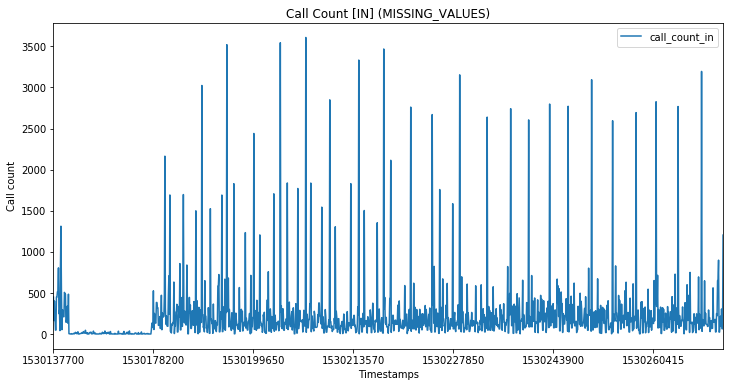

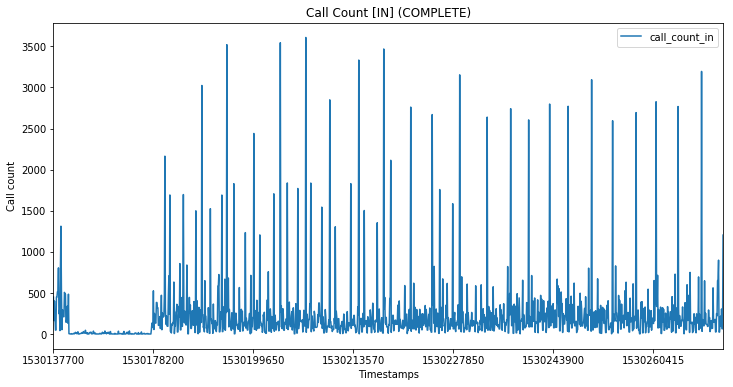

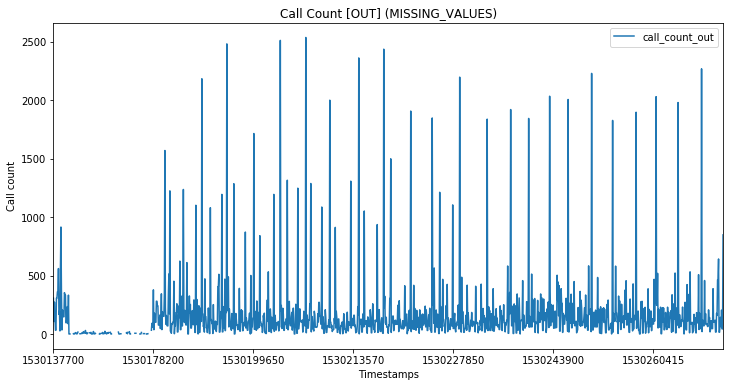

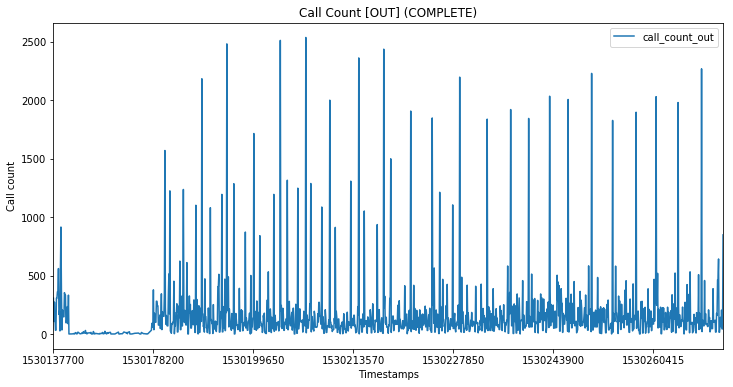

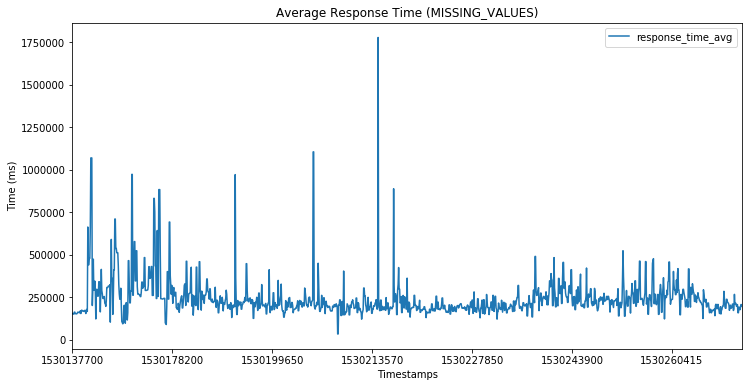

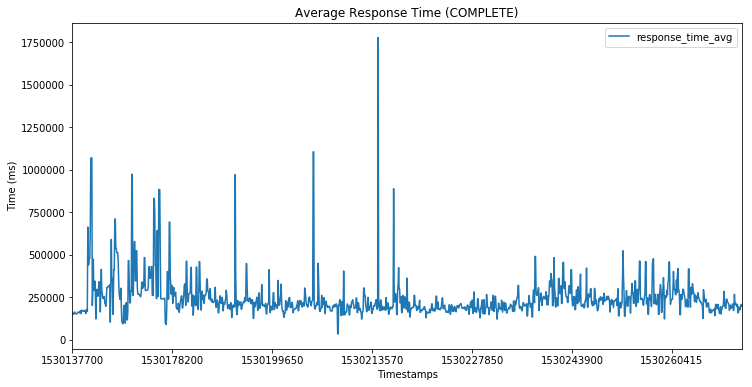

In [6]:
df = df_copy.copy()

df = df.interpolate(method ='linear')

df_copy.plot(x='time', y='call_count_in', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Call count')
plt.title('Call Count [IN] (MISSING_VALUES)')

df.plot(x='time', y='call_count_in', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Call count')
plt.title('Call Count [IN] (COMPLETE)')

df_copy.plot(x='time', y='call_count_out', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Call count')
plt.title('Call Count [OUT] (MISSING_VALUES)')

df.plot(x='time', y='call_count_out', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Call count')
plt.title('Call Count [OUT] (COMPLETE)')

df_copy.plot(x='time', y='response_time_avg', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Time (ms)')
plt.title('Average Response Time (MISSING_VALUES)')

df.plot(x='time', y='response_time_avg', figsize=(12,6))
plt.xlabel('Timestamps')
plt.ylabel('Time (ms)')
plt.title('Average Response Time (COMPLETE)')


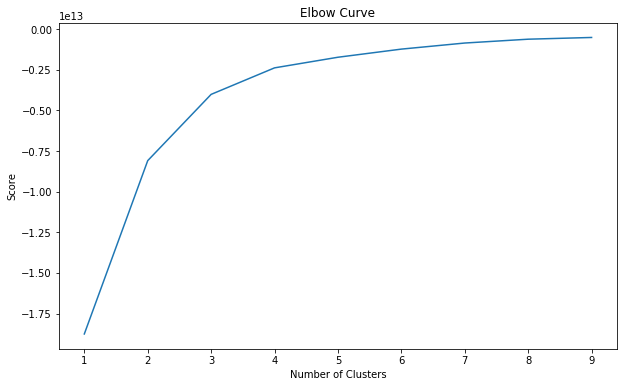

In [7]:
from sklearn.cluster import KMeans

data = df[['call_count_in', 'call_count_in', 'response_time_avg']]
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

# K-Means

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 4 columns):
time                 1341 non-null object
call_count_in        1341 non-null int64
call_count_out       1341 non-null float64
response_time_avg    1341 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 52.4+ KB


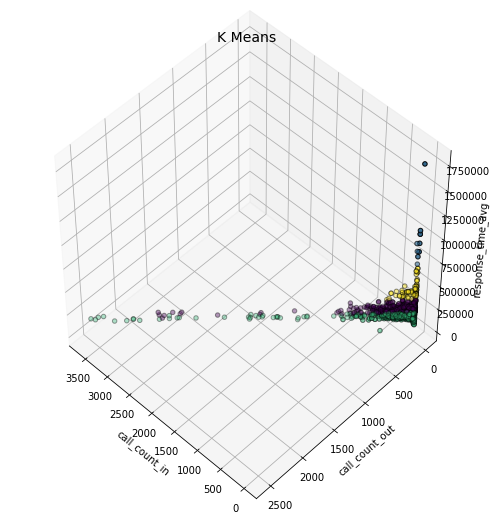

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

df.info()

X = df[['call_count_in', 'call_count_out', 'response_time_avg']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=4)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("call_count_in")
ax.set_ylabel("call_count_out")
ax.set_zlabel("response_time_avg")
plt.title("K Means", fontsize=14);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


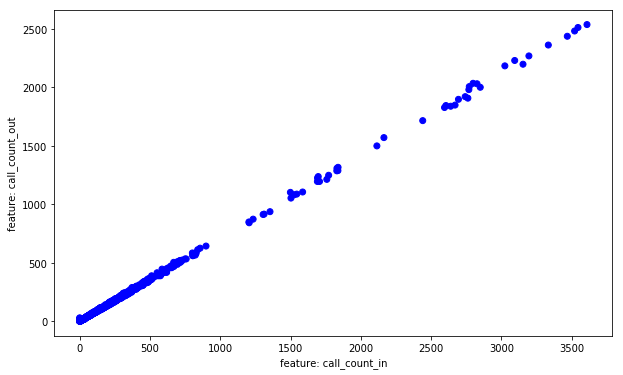

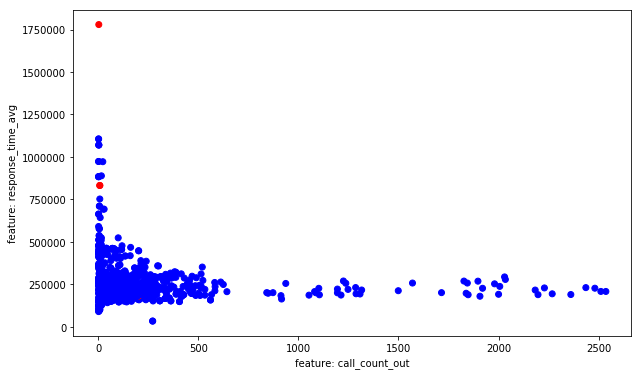

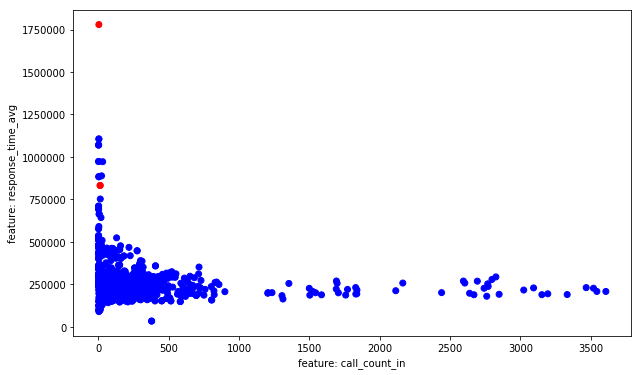

In [9]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

#outliers_fraction = 0.03
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[8])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['call_count_in'], df['call_count_out'], c=df["anomaly"].apply(lambda x: colors[x]))
plt.xlabel('feature: call_count_in')
plt.ylabel('feature: call_count_out')
plt.show();

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['call_count_out'], df['response_time_avg'], c=df["anomaly"].apply(lambda x: colors[x]))
plt.xlabel('feature: call_count_out')
plt.ylabel('feature: response_time_avg')
plt.show();

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['call_count_in'], df['response_time_avg'], c=df["anomaly"].apply(lambda x: colors[x]))
plt.xlabel('feature: call_count_in')
plt.ylabel('feature: response_time_avg')
plt.show();

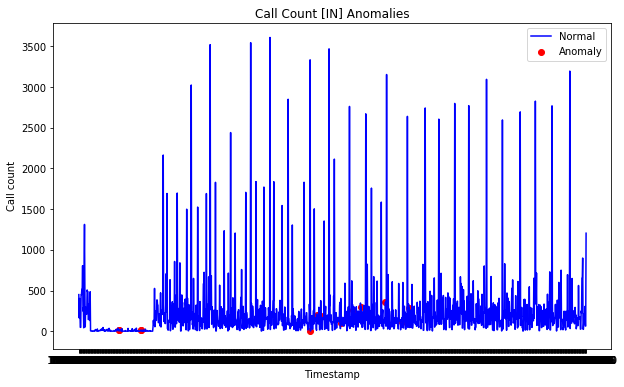

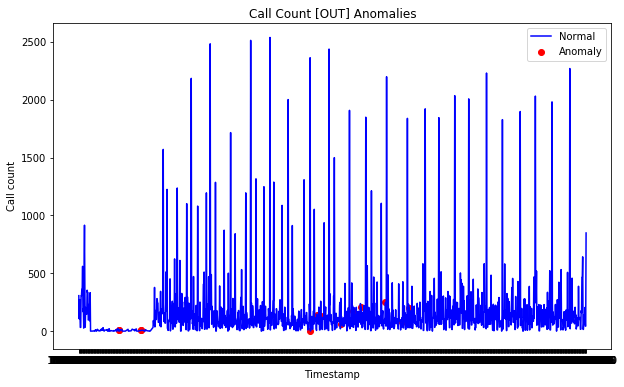

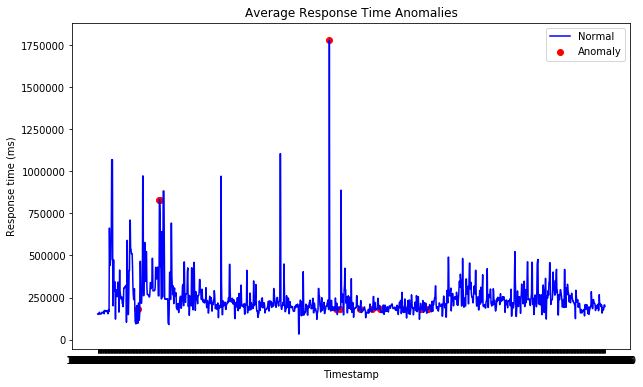

In [10]:
df = df.sort_values('time')
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == 1, ['time', 'call_count_in']] #anomaly

ax.plot(df['time'], df['call_count_in'], color='blue', label='Normal')
ax.scatter(a['time'],a['call_count_in'], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Call count')
plt.title('Call Count [IN] Anomalies')
plt.legend()
plt.show();

fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == 1, ['time', 'call_count_out']] #anomaly

ax.plot(df['time'], df['call_count_out'], color='blue', label='Normal')
ax.scatter(a['time'],a['call_count_out'], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Call count')
plt.title('Call Count [OUT] Anomalies')
plt.legend()
plt.show();

fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == 1, ['time', 'response_time_avg']] #anomaly

ax.plot(df['time'], df['response_time_avg'], color='blue', label='Normal')
ax.scatter(a['time'],a['response_time_avg'], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('Response time (ms)')
plt.title('Average Response Time Anomalies')
plt.legend()
plt.show();

In [11]:
# Print anomalies.
df.loc[df['anomaly'] == 1]

,time,call_count_in,call_count_out,response_time_avg,anomaly
105,1530164430,15,10.0,1.812854e+05,1
107,1530164700,15,10.0,1.812854e+05,1
163,1530172815,12,8.0,8.315812e+05,1
164,1530172830,12,8.0,8.315812e+05,1
612,1530214515,3,3.0,1.779227e+06,1
630,1530215565,199,140.0,1.817984e+05,1
640,1530216285,193,130.0,1.816808e+05,1
693,1530219975,97,66.0,1.806790e+05,1
724,1530221925,266,179.0,1.809020e+05,1
746,1530224130,299,208.0,1.812511e+05,1


# K-Means Iterative

In [12]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

df.info()

outliers_fraction = 0.01

def k_means():
    X = df[['call_count_in', 'call_count_out', 'response_time_avg']]
    X = X.reset_index(drop=True)
    km = KMeans(n_clusters=1)
    km.fit(X)
    km.predict(X)
    labels = km.labels_
    
    def getDistanceByPoint(data, model):
        distance = pd.Series()
        for i in range(0,len(data)):
            Xa = np.array(data.loc[i])
            Xb = model.cluster_centers_[model.labels_[i]-1]
            distance.set_value(i, np.linalg.norm(Xa-Xb))
        return distance

    # get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
    distance = getDistanceByPoint(data, kmeans[8])
    number_of_outliers = int(outliers_fraction*len(distance))
    threshold = distance.nlargest(number_of_outliers).min()

    # anomaly contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
    df['anomaly'] = (distance >= threshold).astype(int)

    # Print anomaly detected in isolation forests algorithm
    anomaly_data = df.loc[df['anomaly'] == 1]
    anomaly_values = anomaly_data[['time', 'call_count_in', 'call_count_out', 'response_time_avg']]
    with open('k_means_1.txt', 'a+') as file:
        file.write('test_{}:\n'.format(iteration))
        file.write(str(anomaly_values))
        file.write('\n\n\n')

    print(anomaly_values)
    
iteration = 0
# for i in range(10):
k_means()
# iteration += 1
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 5 columns):
time                 1341 non-null object
call_count_in        1341 non-null int64
call_count_out       1341 non-null float64
response_time_avg    1341 non-null float64
anomaly              1341 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 62.9+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


           time  call_count_in  call_count_out  response_time_avg
105  1530164430             15            10.0       1.812854e+05
107  1530164700             15            10.0       1.812854e+05
163  1530172815             12             8.0       8.315812e+05
164  1530172830             12             8.0       8.315812e+05
612  1530214515              3             3.0       1.779227e+06
630  1530215565            199           140.0       1.817984e+05
640  1530216285            193           130.0       1.816808e+05
693  1530219975             97            66.0       1.806790e+05
724  1530221925            266           179.0       1.809020e+05
746  1530224130            299           208.0       1.812511e+05
810  1530228300            357           249.0       1.809300e+05
855  1530231285            118            82.0       1.814636e+05
873  1530232530            287           202.0       1.809218e+05


# Isolation Forests

This kind of method detects anomalies purely based on the fact that anomalies are data points that are few and different. The anomalies isolation is implemented without employing any distance or density measure. This method is fundamentally different from clustering based or distance based algorithms.

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


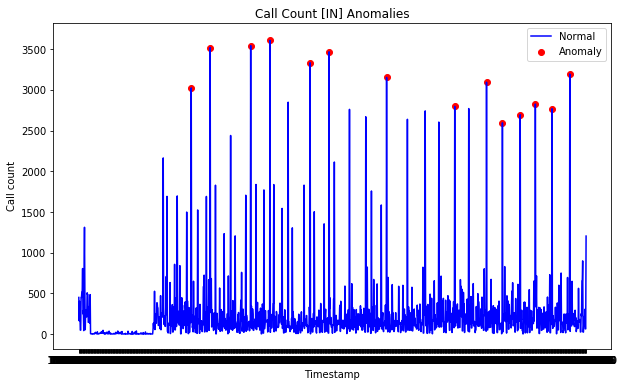

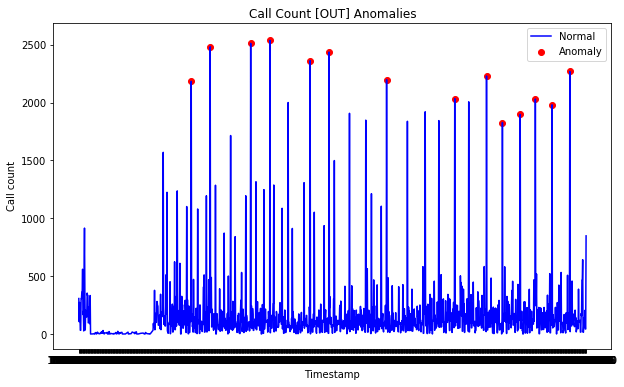

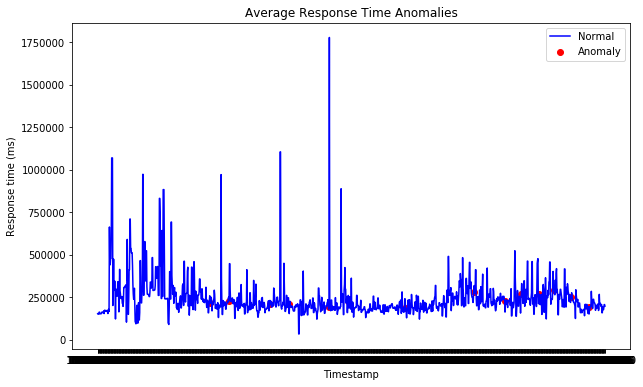

            time  call_count_in  call_count_out  response_time_avg
297   1530192600           3024          2183.0      215694.265625
347   1530196200           3520          2481.0      226560.156250
454   1530203400           3544          2511.0      207595.218750
505   1530207000           3608          2536.0      207435.250000
611   1530214200           3333          2361.0      189323.656250
661   1530217800           3468          2436.0      230065.843750
813   1530228600           3153          2197.0      188516.609375
993   1530243000           2798          2034.0      278116.750000
1077  1530250200           3094          2229.0      228249.328125
1119  1530253800           2595          1827.0      268606.906250
1166  1530257400           2694          1897.0      268030.125000
1206  1530261000           2826          2030.0      293068.156250
1250  1530264600           2768          1980.0      252322.671875
1297  1530268200           3195          2268.0      193556.20

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def isolation_forest():
    rng = np.random.RandomState(0)

    data = df[['call_count_in', 'call_count_out', 'response_time_avg']]
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    model =  IsolationForest(contamination=outliers_fraction, n_jobs=-1, random_state=rng)
    model.fit(data) 
    df['anomaly2'] = pd.Series(model.predict(data))

    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df['anomaly2'] == -1, ['time', 'call_count_in']] #anomaly
    
    ax.plot(df['time'], df['call_count_in'], color='blue', label='Normal')
    ax.scatter(a['time'],a['call_count_in'], color='red', label='Anomaly')
    plt.xlabel('Timestamp')
    plt.ylabel('Call count')
    plt.title('Call Count [IN] Anomalies')
    plt.legend()
    plt.show();
    
    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df['anomaly2'] == -1, ['time', 'call_count_out']] #anomaly
    
    ax.plot(df['time'], df['call_count_out'], color='blue', label='Normal')
    ax.scatter(a['time'],a['call_count_out'], color='red', label='Anomaly')
    plt.xlabel('Timestamp')
    plt.ylabel('Call count')
    plt.title('Call Count [OUT] Anomalies')
    plt.legend()
    plt.show();
    
    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df['anomaly2'] == -1, ['time', 'response_time_avg']] #anomaly
    
    ax.plot(df['time'], df['response_time_avg'], color='blue', label='Normal')
    ax.scatter(a['time'],a['response_time_avg'], color='red', label='Anomaly')
    plt.xlabel('Timestamp')
    plt.ylabel('Response time (ms)')
    plt.title('Average Response Time Anomalies')
    plt.legend()
    plt.show();

    # Print anomaly detected in isolation forests algorithm
    anomaly_data = df.loc[df['anomaly2'] == -1]
    anomaly_values = anomaly_data[['time', 'call_count_in', 'call_count_out', 'response_time_avg']]
    with open('isolation_values_output_1.txt', 'a+') as file:
        file.write('test_{}:\n'.format(iteration))
        file.write(str(anomaly_values))
        file.write('\n\n\n')

    print(anomaly_values)

iteration = 0
# for i in range(10):
isolation_forest()
# iteration += 1

# SVM (Support Vector Machine - Based Anomaly Detection [OneClassSVM])

A SVM is typically associated with supervised learning, but OneClassSVM can be used to identify anomalies as an unsupervised problems that learns a decision function for anomaly detection: classifying new data as similar or different to the training set.

### OneClassSVM
According to the paper: Support Vector Method for Novelty Detection. SVMs are max-margin methods, i.e. they do not model a probability distribution. The idea of SVM for anomaly detection is to find a function that is positive for regions with high density of points, and negative for small densities.

In [14]:
def plot_anomalies(df, anomaly_type, feature_1, feature_2, feature_3, x_val):
    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df[anomaly_type] == -1, [x_val, feature_1]] #anomaly
    
    ax.plot(df[x_val], df[feature_1], color='blue', label='Normal')
    ax.scatter(a[x_val],a[feature_1], color='red', label='Anomaly')
    plt.xlabel('Timestamp')
    plt.ylabel('Call count')
    plt.title('Call Count [IN] Anomalies')
    plt.legend()
    
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(hours)
    
    plt.show()
    plt.draw()
    
    fig.savefig('anomalies_call_count_in' + '.svg', format="svg")
    
    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df[anomaly_type] == -1, [x_val, feature_2]] #anomaly
    
    ax.plot(df[x_val], df[feature_2], color='blue', label='Normal')
    ax.scatter(a[x_val],a[feature_2], color='red', label='Anomaly')
    plt.xlabel('Timestamp')
    plt.ylabel('Call count')
    plt.title('Call Count [OUT] Anomalies')
    plt.legend()
    
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(hours)
    
    plt.show()
    plt.draw()
    
    fig.savefig('anomalies_call_count_out' + '.svg', format="svg")
    
    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df['anomaly3'] == -1, [x_val, feature_3]] #anomaly
    
    ax.plot(df[x_val], df[feature_3], color='blue', label='Normal')
    ax.scatter(a[x_val],a[feature_3], color='red', label='Anomaly')
    plt.xlabel('Timestamp')
    plt.ylabel('Response time (ms)')
    plt.title('Average Response Time Anomalies')
    plt.legend()
    
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(hours)
    
    plt.show()
    plt.draw()
    
    #fig.savefig('anomalies_response_time_avg' + '.svg', format="svg")

In [15]:
def plot_anomalies_single_plt(df, anomaly_type, feature_1, feature_2, feature_3, x_val):
    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df[anomaly_type] == -1, [x_val, feature_1]] #anomaly
    
    ax.plot(df[x_val], df[feature_1], color='blue', label=feature_1)
    ax.scatter(a[x_val],a[feature_1], color='red', label='Anomaly')
    
    a = df.loc[df[anomaly_type] == -1, [x_val, feature_2]] #anomaly
    
    ax.plot(df[x_val], df[feature_2], color='green', label=feature_2)
    ax.scatter(a[x_val],a[feature_2], color='red', label='Anomaly')
    
    a = df.loc[df[anomaly_type] == -1, [x_val, feature_3]] #anomaly
    
    ax.plot(df[x_val], df[feature_3], color='yellow', label=feature_3)
    ax.scatter(a[x_val],a[feature_3], color='red', label='Anomaly')
    
    plt.xlabel('Time (Day Hour)')
    plt.ylabel('Feature ratio')
    plt.title('Anomalies')
    plt.legend()
    
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(hours)
    
    plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


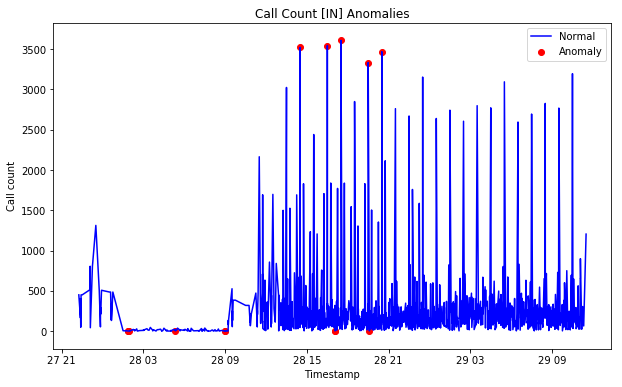

<Figure size 432x288 with 0 Axes>

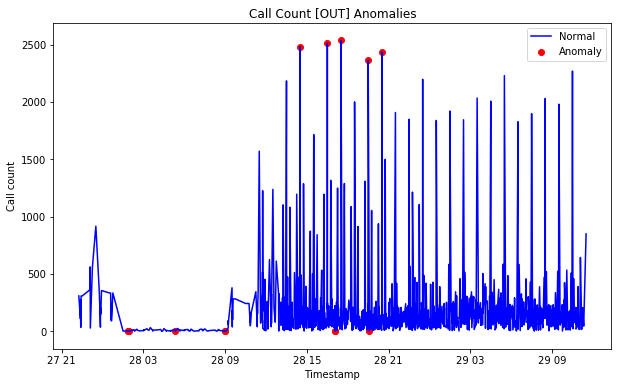

<Figure size 432x288 with 0 Axes>

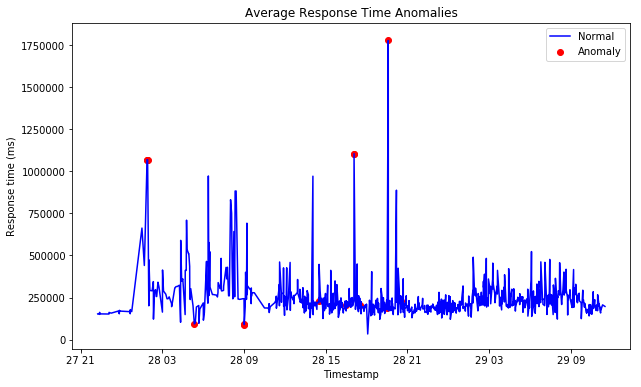

               datetime  call_count_in  call_count_out  response_time_avg
37  2018-06-28 01:52:15              1             2.5       1.069827e+06
38  2018-06-28 01:52:30              1             3.0       1.069827e+06
39  2018-06-28 01:55:00              1             3.5       1.069827e+06
101 2018-06-28 05:20:45              6             4.0       9.282000e+04
187 2018-06-28 09:00:30              6             4.0       9.355400e+04
188 2018-06-28 09:00:45              3             2.0       8.883900e+04
347 2018-06-28 14:30:00           3520          2481.0       2.265602e+05
454 2018-06-28 16:30:00           3544          2511.0       2.075952e+05
482 2018-06-28 17:04:15              3             2.0       1.105517e+06
483 2018-06-28 17:04:30              3             2.0       1.105517e+06
505 2018-06-28 17:30:00           3608          2536.0       2.074352e+05
611 2018-06-28 19:30:00           3333          2361.0       1.893237e+05
612 2018-06-28 19:35:15              3

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

import matplotlib.dates as mdates

hours = mdates.HourLocator(interval=6)  # every day
dateFmt = mdates.DateFormatter('%d %H')

def one_class_svm(x_val):
    data = df[['call_count_in', 'call_count_out', 'response_time_avg']]
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    # train oneclassSVM 
    model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
    model.fit(data)
    df['anomaly3'] = pd.Series(model.predict(data))

    plot_anomalies(df, 'anomaly3', 'call_count_in', 'call_count_out', 'response_time_avg', x_val)
    
    # Print anomaly detected in isolation forests algorithm
    anomaly_data = df.loc[df['anomaly3'] == -1]
    anomaly_values = anomaly_data[[x_val, 'call_count_in', 'call_count_out', 'response_time_avg']]
    with open('one_class_svm_values_output_1.txt', 'a+') as file:
        file.write('test_{}:\n'.format(iteration))
        file.write(str(anomaly_values))
        file.write('\n\n\n')

    print(anomaly_values)


# Parse timestamps to datetime
df['datetime'] = pd.to_datetime(df['time'], unit='s')

#iteration = 0
one_class_svm('datetime')


In [17]:
max_feature_1 = df.loc[df['call_count_in'].idxmax()]['call_count_in']
max_feature_2 = df.loc[df['call_count_out'].idxmax()]['call_count_out']
max_feature_3 = df.loc[df['response_time_avg'].idxmax()]['response_time_avg']

print(max_feature_1)
print(max_feature_2)
print(max_feature_3)

df['call_count_in_ratio'] = df.apply(lambda row: row.call_count_in / max_feature_1, axis=1)
df['call_count_out_ratio'] = df.apply(lambda row: row.call_count_out / max_feature_2, axis=1)
df['response_time_avg_ratio'] = df.apply(lambda row: row.response_time_avg / max_feature_3, axis=1)

df

3608
2536.0
1779227.0


,time,call_count_in,call_count_out,response_time_avg,anomaly,anomaly2,datetime,anomaly3,call_count_in_ratio,call_count_out_ratio,response_time_avg_ratio
0,1530137700,450,308.0,152401.703125,0,1,2018-06-27 22:15:00,1,0.124723,0.121451,0.085656
1,1530138135,163,108.0,154017.812500,0,1,2018-06-27 22:22:15,1,0.045177,0.042587,0.086564
2,1530138150,402,274.0,151387.281250,0,1,2018-06-27 22:22:30,1,0.111419,0.108044,0.085086
3,1530138165,239,166.0,149441.390625,0,1,2018-06-27 22:22:45,1,0.066242,0.065457,0.083992
4,1530138195,48,34.0,161604.000000,0,1,2018-06-27 22:23:15,1,0.013304,0.013407,0.090828
5,1530138210,48,34.0,161604.000000,0,1,2018-06-27 22:23:30,1,0.013304,0.013407,0.090828
6,1530138300,450,308.0,152401.703125,0,1,2018-06-27 22:25:00,1,0.124723,0.121451,0.085656
7,1530138600,450,308.0,152401.703125,0,1,2018-06-27 22:30:00,1,0.124723,0.121451,0.085656
8,1530140670,515,363.0,151700.781250,0,1,2018-06-27 23:04:30,1,0.142738,0.143139,0.085262
9,1530140685,515,363.0,151700.781250,0,1,2018-06-27 23:04:45,1,0.142738,0.143139,0.085262


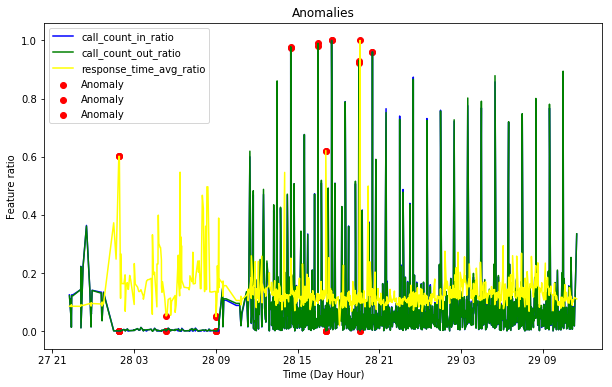

In [18]:
plot_anomalies_single_plt(df, 'anomaly3', 'call_count_in_ratio', 'call_count_out_ratio', 'response_time_avg_ratio', 'datetime')

In [19]:
STATIC_DF = df.copy()

In [20]:
service_names = ['nova-api-cascading']

metric_pre_name = 'huawei'

metric_single_type = ['graph_variance', 'graph_gain_variance', 'graph_loss_variance']

metric_double_types = ['call_count', 'call_count_in', 'call_count_out', 
                         'response_time_avg', 
                         'degree', 'degree_in', 'degree_out']

metric_status_code = 'status_code'

metric_triple_types_1 = ['1XX', '2XX', '3XX', '4XX', '5XX']

metric_names = list()

# Single param metric
for metric_type in metric_single_type:
    metric_names.append('{}.{}'.format(metric_pre_name, metric_type))

# Double param metric
for service_name in service_names:
    for metric_type in metric_double_types:
        metric_names.append('{}.{}.{}'.format(metric_pre_name, metric_type, service_name))
        

# Triple param metric
for service_name in service_names:
    for metric_type in metric_triple_types_1:
        metric_names.append('{}.{}.{}.{}'.format(metric_pre_name, metric_status_code, service_name, metric_type))

n_metric_names = list()    
    
for metric in metric_names:
    print(metric)
    if 'response_time' in metric or 'call_count' in metric:
        continue
    n_metric_names.append(metric)

n_metric_names

huawei.graph_variance
huawei.graph_gain_variance
huawei.graph_loss_variance
huawei.call_count.nova-api-cascading
huawei.call_count_in.nova-api-cascading
huawei.call_count_out.nova-api-cascading
huawei.response_time_avg.nova-api-cascading
huawei.degree.nova-api-cascading
huawei.degree_in.nova-api-cascading
huawei.degree_out.nova-api-cascading
huawei.status_code.nova-api-cascading.1XX
huawei.status_code.nova-api-cascading.2XX
huawei.status_code.nova-api-cascading.3XX
huawei.status_code.nova-api-cascading.4XX
huawei.status_code.nova-api-cascading.5XX


['huawei.graph_variance',
 'huawei.graph_gain_variance',
 'huawei.graph_loss_variance',
 'huawei.degree.nova-api-cascading',
 'huawei.degree_in.nova-api-cascading',
 'huawei.degree_out.nova-api-cascading',
 'huawei.status_code.nova-api-cascading.1XX',
 'huawei.status_code.nova-api-cascading.2XX',
 'huawei.status_code.nova-api-cascading.3XX',
 'huawei.status_code.nova-api-cascading.4XX',
 'huawei.status_code.nova-api-cascading.5XX']

In [30]:
df_list = list()

for metric_name in n_metric_names:
    metrics = opentsdb.get_metrics(metric_name, start_timestamp, end_timestamp)

    splited_metric_name = metric_name.split('.')
    column_name = ''
    
    if metric_name.count('.') == 1:
        column_name = splited_metric_name[1]
    elif metric_name.count('.') == 2:
        column_name = splited_metric_name[1]
    elif metric_name.count('.') == 3:
        column_name = splited_metric_name[1] + '.' + splited_metric_name[3]
    else:
        print('FUCK!')

    if metrics is None:
        print(column_name + ' is empty!')
        continue
    
    df = pd.DataFrame(metrics.items(), columns=['time', column_name])
    
    df_list.append(df)

status_code.1XX is empty!
status_code.3XX is empty!


In [31]:
df

,time,status_code.5XX
0,1530253800,0.000806
1,1530254700,0.003992
2,1530254835,0.022727
3,1530254850,0.022727
4,1530260100,0.029613
5,1530260370,0.051587
6,1530260385,0.065327
7,1530261000,0.002842


In [71]:
# Concatenate multiple dataframes
complete_df = STATIC_DF

complete_df = complete_df.set_index('time')

for df in df_list:
    df = df.set_index('time')
    complete_df = pd.concat([complete_df, df], ignore_index=False)

complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11846 entries, 1530137700 to 1530261000
Data columns (total 19 columns):
anomaly                    1341 non-null float64
anomaly2                   1341 non-null float64
anomaly3                   1341 non-null float64
call_count_in              1341 non-null float64
call_count_in_ratio        1341 non-null float64
call_count_out             1341 non-null float64
call_count_out_ratio       1341 non-null float64
datetime                   1341 non-null datetime64[ns]
degree                     1341 non-null float64
degree_in                  1341 non-null float64
degree_out                 1341 non-null float64
graph_gain_variance        1344 non-null float64
graph_loss_variance        1344 non-null float64
graph_variance             1344 non-null float64
response_time_avg          1341 non-null float64
response_time_avg_ratio    1341 non-null float64
status_code.2XX            1274 non-null float64
status_code.4XX            1168 non-null f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [72]:
complete_df = complete_df.drop(columns=['anomaly', 'anomaly2'])

In [73]:
complete_df

,anomaly3,call_count_in,call_count_in_ratio,call_count_out,call_count_out_ratio,datetime,degree,degree_in,degree_out,graph_gain_variance,graph_loss_variance,graph_variance,response_time_avg,response_time_avg_ratio,status_code.2XX,status_code.4XX,status_code.5XX
time,,,,,,,,,,,,,,,,,
1530137700,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:15:00,NaN,NaN,NaN,NaN,NaN,NaN,152401.703125,0.085656,NaN,NaN,NaN
1530138135,1.0,163.0,0.045177,108.0,0.042587,2018-06-27 22:22:15,NaN,NaN,NaN,NaN,NaN,NaN,154017.812500,0.086564,NaN,NaN,NaN
1530138150,1.0,402.0,0.111419,274.0,0.108044,2018-06-27 22:22:30,NaN,NaN,NaN,NaN,NaN,NaN,151387.281250,0.085086,NaN,NaN,NaN
1530138165,1.0,239.0,0.066242,166.0,0.065457,2018-06-27 22:22:45,NaN,NaN,NaN,NaN,NaN,NaN,149441.390625,0.083992,NaN,NaN,NaN
1530138195,1.0,48.0,0.013304,34.0,0.013407,2018-06-27 22:23:15,NaN,NaN,NaN,NaN,NaN,NaN,161604.000000,0.090828,NaN,NaN,NaN
1530138210,1.0,48.0,0.013304,34.0,0.013407,2018-06-27 22:23:30,NaN,NaN,NaN,NaN,NaN,NaN,161604.000000,0.090828,NaN,NaN,NaN
1530138300,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:25:00,NaN,NaN,NaN,NaN,NaN,NaN,152401.703125,0.085656,NaN,NaN,NaN
1530138600,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,152401.703125,0.085656,NaN,NaN,NaN
1530140670,1.0,515.0,0.142738,363.0,0.143139,2018-06-27 23:04:30,NaN,NaN,NaN,NaN,NaN,NaN,151700.781250,0.085262,NaN,NaN,NaN


In [74]:
complete_df = complete_df.interpolate(method ='linear', limit_direction = 'both')

column_headers = complete_df.columns.values
column_headers[0] = 'anomaly'

column_headers

complete_df.columns = column_headers 

complete_df

,anomaly,call_count_in,call_count_in_ratio,call_count_out,call_count_out_ratio,datetime,degree,degree_in,degree_out,graph_gain_variance,graph_loss_variance,graph_variance,response_time_avg,response_time_avg_ratio,status_code.2XX,status_code.4XX,status_code.5XX
time,,,,,,,,,,,,,,,,,
1530137700,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:15:00,3.0,2.0,1.0,0.0,0.0,0.0,152401.703125,0.085656,0.280543,0.719457,0.000806
1530138135,1.0,163.0,0.045177,108.0,0.042587,2018-06-27 22:22:15,3.0,2.0,1.0,0.0,0.0,0.0,154017.812500,0.086564,0.280543,0.719457,0.000806
1530138150,1.0,402.0,0.111419,274.0,0.108044,2018-06-27 22:22:30,3.0,2.0,1.0,0.0,0.0,0.0,151387.281250,0.085086,0.280543,0.719457,0.000806
1530138165,1.0,239.0,0.066242,166.0,0.065457,2018-06-27 22:22:45,3.0,2.0,1.0,0.0,0.0,0.0,149441.390625,0.083992,0.280543,0.719457,0.000806
1530138195,1.0,48.0,0.013304,34.0,0.013407,2018-06-27 22:23:15,3.0,2.0,1.0,0.0,0.0,0.0,161604.000000,0.090828,0.280543,0.719457,0.000806
1530138210,1.0,48.0,0.013304,34.0,0.013407,2018-06-27 22:23:30,3.0,2.0,1.0,0.0,0.0,0.0,161604.000000,0.090828,0.280543,0.719457,0.000806
1530138300,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:25:00,3.0,2.0,1.0,0.0,0.0,0.0,152401.703125,0.085656,0.280543,0.719457,0.000806
1530138600,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:30:00,3.0,2.0,1.0,0.0,0.0,0.0,152401.703125,0.085656,0.280543,0.719457,0.000806
1530140670,1.0,515.0,0.142738,363.0,0.143139,2018-06-27 23:04:30,3.0,2.0,1.0,0.0,0.0,0.0,151700.781250,0.085262,0.280543,0.719457,0.000806


In [75]:
complete_df['datetime'] = pd.to_datetime(complete_df.index, unit='s')

complete_df

,anomaly,call_count_in,call_count_in_ratio,call_count_out,call_count_out_ratio,datetime,degree,degree_in,degree_out,graph_gain_variance,graph_loss_variance,graph_variance,response_time_avg,response_time_avg_ratio,status_code.2XX,status_code.4XX,status_code.5XX
time,,,,,,,,,,,,,,,,,
1530137700,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:15:00,3.0,2.0,1.0,0.0,0.0,0.0,152401.703125,0.085656,0.280543,0.719457,0.000806
1530138135,1.0,163.0,0.045177,108.0,0.042587,2018-06-27 22:22:15,3.0,2.0,1.0,0.0,0.0,0.0,154017.812500,0.086564,0.280543,0.719457,0.000806
1530138150,1.0,402.0,0.111419,274.0,0.108044,2018-06-27 22:22:30,3.0,2.0,1.0,0.0,0.0,0.0,151387.281250,0.085086,0.280543,0.719457,0.000806
1530138165,1.0,239.0,0.066242,166.0,0.065457,2018-06-27 22:22:45,3.0,2.0,1.0,0.0,0.0,0.0,149441.390625,0.083992,0.280543,0.719457,0.000806
1530138195,1.0,48.0,0.013304,34.0,0.013407,2018-06-27 22:23:15,3.0,2.0,1.0,0.0,0.0,0.0,161604.000000,0.090828,0.280543,0.719457,0.000806
1530138210,1.0,48.0,0.013304,34.0,0.013407,2018-06-27 22:23:30,3.0,2.0,1.0,0.0,0.0,0.0,161604.000000,0.090828,0.280543,0.719457,0.000806
1530138300,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:25:00,3.0,2.0,1.0,0.0,0.0,0.0,152401.703125,0.085656,0.280543,0.719457,0.000806
1530138600,1.0,450.0,0.124723,308.0,0.121451,2018-06-27 22:30:00,3.0,2.0,1.0,0.0,0.0,0.0,152401.703125,0.085656,0.280543,0.719457,0.000806
1530140670,1.0,515.0,0.142738,363.0,0.143139,2018-06-27 23:04:30,3.0,2.0,1.0,0.0,0.0,0.0,151700.781250,0.085262,0.280543,0.719457,0.000806


In [80]:
unique_anomalies_count = complete_df['anomaly'].value_counts()

unique_anomalies_count

 1.0    11832
-1.0       14
Name: anomaly, dtype: int64

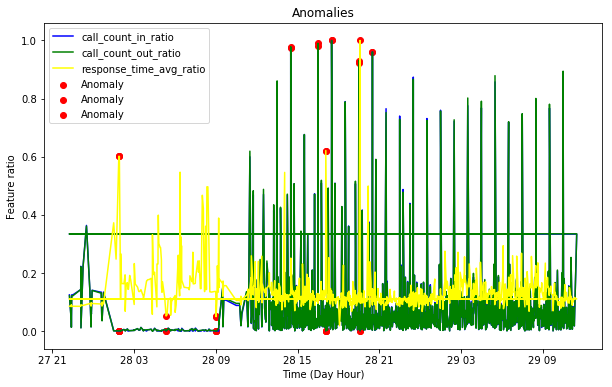

In [76]:
plot_anomalies_single_plt(complete_df, 'anomaly', 'call_count_in_ratio', 'call_count_out_ratio', 'response_time_avg_ratio', 'datetime')

In [77]:
complete_df.to_csv ('anomalous_sample_data.csv', index = True, header=True)